# Project 4 [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/discussion) Baseline Model

## W207 Applied Machine Learning
## Group members: Julia Ying, Haerang Lee, Sang-hyeb Lee
## Date: March/14/2020



# 0. Setup

tf version: 2.2.0-rc2
pandas version: 1.0.3
keras version: 2.3.0-tf


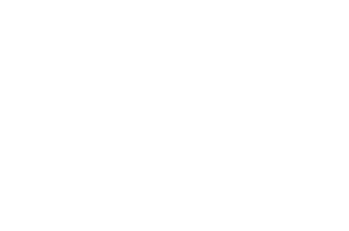

In [28]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import transform
from skimage.transform import AffineTransform

print(f"tf version: {tf.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"keras version: {keras.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
plt.rcParams['figure.figsize'] = [10, 10]
IMAGE_WIDTH = 96
np.random.seed(0)

# 1. Download data from Kaggle

In [6]:
!pip install kaggle   #install kaggle library
!mkdir ~/.kaggle         #make a directory named .kaggle 
files.upload() # upload kaggle.json (it contains your API token) file 
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/*
!chmod 600 ~/.kaggle/kaggle.json  
!kaggle datasets list
!kaggle competitions download -c facial-keypoints-detection

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json
/root/.kaggle/kaggle.json
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-03 22:53:52          41501  
fireballbyedimyrnmom/us-counties-covid-19-dataset              US counties COVID 19 dataset                        226KB  2020-04-03 20:29:13            675  
ryanxjhan/cbc-news-coronavirus-articles-march-26               CBC News Coronavirus/COVID-19 Articles (NLP)          6MB  2020-03-27 23:23:07            287  
vitaliymalcev/russian-passenger-air-service-20072020           Russian passenger air service 2007-2020             239KB  2020-04-02 22:27:03    

In [4]:
!ls

sample_data


# 2. Data Preprocessing & Exploratory Data Analysis

In [0]:
# load data
train_data = pd.read_csv("training.zip")
test_data = pd.read_csv("test.zip")
meta_data = pd.read_csv("IdLookupTable.csv")

In [13]:
# let's look at train data set
train_data.info()
train_data.head(5).T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


There are 31 columns in this dataset. Each column except the last one represents a facial feature point as a float in given diemsion. Last column contains image dataset as a string. Let's check if there is any missing dataset

In [14]:
print(train_data.isnull().any().value_counts())
train_data.columns[train_data.isnull().any()]

True     28
False     3
dtype: int64


Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'mouth_left_corner_x',
       'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype='object')

Out of 31 columns, there are 28 columns which have missing values.


In [15]:
# find out number of number of rows with missing values
print(f"Total number of rows: {train_data.shape[0]}")
print(f"Total number of rows with NaN : {train_data.shape[0] - train_data.dropna().shape[0]}")

Total number of rows: 7049
Total number of rows with NaN : 4909


There are `4909` rows with missing values. It looks like there are two groups of features in the dataset. First group of features have the number of rows between 7016 ~ 7049. These are `left_eye_center_x `, `left_eye_center_y`, `right_eye_center_x`, `right_eye_center_y`, `mouth_center_bottom_lip_x`, and `mouth_center_bottom_lip_y`. Second group of features have the number of rows between 2225 ~ 2275. How do we handle this? Should we create two different models to handle each group? Or move the rows with missing values? Or fill in missing values other values. 


In [0]:
# for now, use values from the previous rows
train_data.fillna(method="ffill", inplace = True)

Let's convert image object to numpy array and store them in *X_train*

In [17]:
def convert_df_to_np_2d(df: pd.Series, image_size: int) -> np.ndarray:
  dataset = np.hstack(train_data["Image"].apply(lambda row:np.fromstring(row,sep=' ')).to_numpy())
  dataset = dataset.astype(np.float32)
  dataset = dataset.reshape(-1,image_size,image_size,1)
  return dataset

X_train = convert_df_to_np_2d(train_data["Image"], IMAGE_WIDTH)
print(X_train.shape)

(7049, 96, 96, 1)


Let's store predictor variables in *y_train*

In [20]:
y_train = np.delete(train_data.to_numpy(),-1,axis=1).astype(np.float32) #removing the last column(Image)
y_train.dtype

ERROR! Session/line number was not unique in database. History logging moved to new session 

dtype('float32')

59


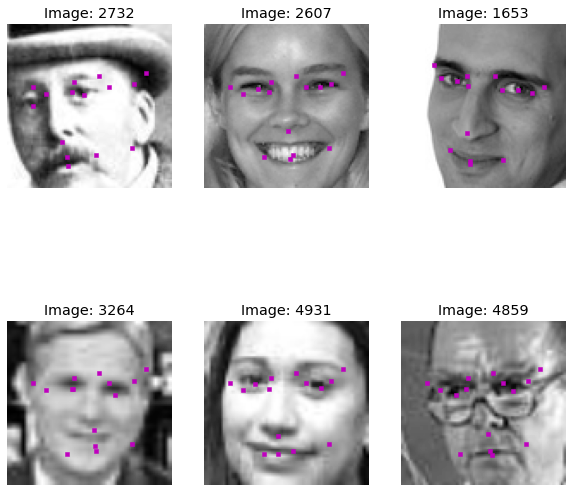

In [80]:
def show_image(img: np.ndarray):
  plt.axis('off')
  plt.imshow(img[:,:,0],cmap="gray")

def show_image_with_key_points(img: np.ndarray, key_points: np.ndarray, image_number, axis):
  axis.axis('off')
  axis.imshow(img[:,:,0],cmap="gray")
  axis.scatter(key_points[0:30:2],key_points[1:30:2], s=10,marker=',',c='m')
  axis.set_title(f"Image: {image_number}")

def show_multiple_samples(image_set: np.ndarray, feature_set: np.ndarray, number_of_images: int, images_per_row = 3):
  fig, axis = plt.subplots(number_of_images//images_per_row, images_per_row)
  for i in range(number_of_images):
    image_number = np.random.randint(0, image_set.shape[0])
    show_image_with_key_points(image_set[image_number], feature_set[image_number], 
                              image_number , axis[i//images_per_row,
                                                  i%images_per_row])
show_multiple_samples(X_train,y_train, 6)

Let's preprocess the test data set and store it in *X_test*


In [215]:
test_data.fillna(method="ffill", inplace = True)
test_data.head(5).T
X_test = convert_df_to_np_2d(test_data["Image"], IMAGE_WIDTH)
print(X_test.shape)

(7049, 96, 96, 1)


# 3. BaseLine Model using Naive LeNet-5

In [216]:
def create_naive_LeNet5_model(input_shape):
  print(f"Initializing LeNet5 model with input-size: {input_shape}")
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape))
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=30))
  return model

LeNet5_model = create_naive_LeNet5_model(X_train.shape[1:])
LeNet5_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

Initializing LeNet5 model with input-size: (96, 96, 1)


In [0]:
#train it!
result = LeNet5_model.fit(X_train,y_train,epochs = 50,batch_size = 256,validation_split = 0.2)

In [0]:
# save it
LeNet5_model.save("baseline-LeNet5.h5")

In [0]:
# let's plot validation and train loss
def plot_history(history, name, RMSE_TF=False):
  loss = history['loss']
  val_loss = history['val_loss']
  plt.plot(figsize=(15,10))
  plt.plot(loss,"--",linewidth=3,label="train:"+name)
  plt.plot(val_loss,linewidth=3,label="val:"+name)
  plt.yscale("log")
  plt.xlabel("epoch")
  plt.ylabel("log loss")
  plt.legend()
  plt.grid(True)
plot_history(result.history, "Baseline - LeNet5")

Evaluate the model performance against test data

In [0]:
y_test = LeNet5_model.predict(X_test)

In [0]:
show_multiple_samples(X_test, y_test, 6)

# 4. VGG-16 with data augmentation & transfer learning(image-net) 

- Our dataset consists of few thousand entries. We can only learn small set of common features from this dataset. The idea behind transfer learning is to use an existing model that has been already trained on far more data as start a starting point and use the features that model has learned. Specifically, we are borrowing the convolutional neural network layers which were trained to extract features for much larger dataset. In this model, we will be using the model that has been trained on a dataset from [ImageNet](http://image-net.org) which has over 1.4 million images. 


## Data Augmentation (Based off Julia's work)

Keras provides a convinient API, `ImageDataGenerator`, to handle provides data augmentation. However it only applies transformation to the data not the landmarks. Therefore, we created a new class `FacialPointImageDataGenerator` to handle this issue.

In [0]:
class FacialPointImageDataGenerator(keras.utils.Sequence):
  '''FacialPointImageDataGenerator'''
  def __init__(self, X_data, y_data,horizontal_flip_prob=0, horizontall_flip_label=None,
               horizontal_shift_range=0.1, horizontal_shift_prob=0,
               shift_range = 0, 
               affine_transformation_prob = 0,
               to_fit=True, batch_size=32, image_size=(96,96), n_channels=1,
               shuffle=True, convertToRGB=True):
    self.to_fit = to_fit
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.horizontal_flip_prob = horizontal_flip_prob
    self.horizontal_center = image_size[0]//2;
    self.horizontal_flip_batch_size = int(horizontal_flip_prob * batch_size)
    # need to update the labels if we flip the image horizontally
    # for example left_eye_center_x becomes right_eye_center_x
    self.horizontal_flip_label = {"orig" : [0, 1, 4, 5, 6, 7, 12, 13, 14, 15, 22, 23],
                  "new"  : [2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25]} if  horizontall_flip_label is None else horizontall_flip_label

    self.horizontal_flip_fn = np.vectorize(self.horizontal_flip)
    self.shift_range = shift_range
    self.w_shift_max = int(image_size[0] * shift_range)
    self.h_shift_max = int(image_size[1] * shift_range)
    self.affine_transformation_prob = affine_transformation_prob
    
    self.X_data = y_data
    self.y_data = y_data
    self.convertToRGB = convertToRGB #need it to use pre-trained VGG16 which expects RGB(3-channel) data
    self.on_epoch_end()

  #helpfer function for performing horizontal flip
  @staticmethod
  def horizontal_flip(element ,center):
    if element < center:
      element = center + (center - element)
    else:
      element = center - (element - center)
    return element
  
  #helpfer function for performing affine transformation
  def transform_image(self, X_data, y_data):
      translation = (np.random.uniform(-1*self.w_shift_max, self.w_shift_max),
                    np.random.uniform(-1*self.h_shift_max, self.h_shift_max))
      
      transformation_matrix = AffineTransform(
            translation=translation
      )

      X_transformed = transform.warp(X_data, transformation_matrix, mode="edge")
      y_data[::2] += -translation[0]
      y_data[1::2] += -translation[1]
      return (X_transformed, y_data)

  def __len__(self):
    '''Number of batches per epoch'''
    return self.X_data.shape[0] // self.batch_size
  
  def on_epoch_end(self):
    '''Called at the end of every epoch. Shuffle indices?'''
    self.indexes = np.arange(self.X_data.shape[0])
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __getitem__(self, index):
    '''Generate one batch of data'''
    #generate indexes
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    #get the data
    X_batch = X_train[indexes]
    y_batch = y_train[indexes]

    #handle horizontal flip
    if self.horizontal_flip_prob > 0:
      horizontal_flip_index = np.random.choice(self.batch_size, self.horizontal_flip_batch_size, replace=False)
      X_batch[horizontal_flip_index] = X_batch[horizontal_flip_index, :, ::-1,:]
      for index in horizontal_flip_index:
        target_y = y_batch[index]
        target_y_rotated = self.horizontal_flip_fn(target_y, self.horizontal_center)
        target_y_rotated[1::2] = target_y[1::2]
        ## need to flip indicies
        y_batch_orig = target_y_rotated[self.horizontal_flip_label["orig"]]
        target_y_rotated[self.horizontal_flip_label["orig"]] = target_y_rotated[self.horizontal_flip_label["new"]]
        target_y_rotated[self.horizontal_flip_label["new"]]  = y_batch_orig   
        y_batch[index] = target_y_rotated

    #handle affine transformation
    if self.affine_transformation_prob > 0:
      for index in range(self.batch_size):
        X_batch[index], y_batch[index] = self.transform_image(X_batch[index],y_batch[index])
    
    if self.convertToRGB:
      X_batch = np.repeat(X_batch,3,axis=-1)
    return X_batch, y_batch


Let's check if horizontal flip function works!

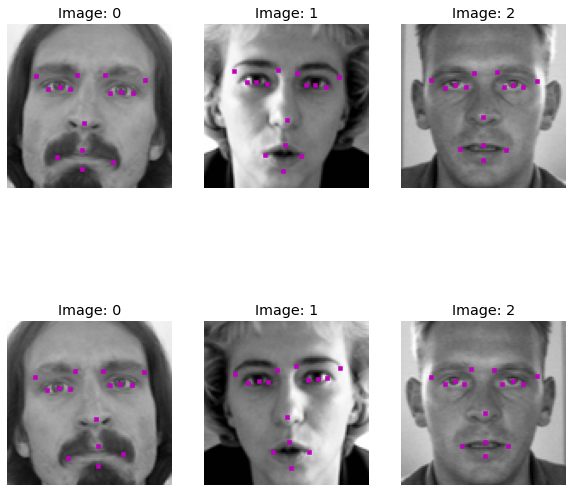

In [174]:
params = {
    'X_data': X_train,
    'y_data': y_train,
    'shuffle': False
}

train_datagen_normal = FacialPointImageDataGenerator(horizontal_flip_prob=0,**params)
train_datagen_flipped = FacialPointImageDataGenerator(horizontal_flip_prob=1.0,**params)

X_normal, y_normal = train_datagen_normal[0]
X_flipped, y_flipped = train_datagen_flipped[0]
_,axes = plt.subplots(2,3)


for i in range(3):
  show_image_with_key_points(X_normal[i], y_normal[i], i, axes[0,i])
  show_image_with_key_points(X_flipped[i], y_flipped[i], i, axes[1,i])
  


#train it!
#result = LeNet5_model.fit_generator(generator=train_datagen, epochs = 50)

Let's check if horizontal shift works!

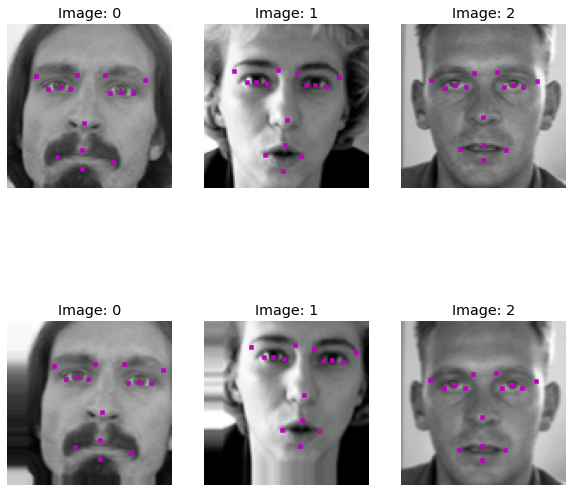

In [184]:
params = {
    'X_data': X_train,
    'y_data': y_train,
    'shift_range': 0.15,
    'shuffle': False
}

train_datagen_normal = FacialPointImageDataGenerator(affine_transformation_prob=0.0,**params)
train_datagen_flipped = FacialPointImageDataGenerator(affine_transformation_prob=1.0,**params)

X_normal, y_normal = train_datagen_normal[0]
X_flipped, y_flipped = train_datagen_flipped[0]
_,axes = plt.subplots(2,3)


for i in range(3):
  show_image_with_key_points(X_normal[i], y_normal[i], i, axes[0,i])
  show_image_with_key_points(X_flipped[i], y_flipped[i], i, axes[1,i])


## Model with transferred learning

In [211]:
def create_vgg16_model_with_transfer_learning(input_shape):
  #need to have RGB
  
  #load VGG16 model pre-trained with imagenet
  pre_trained_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
  
  #freeze convolutional layers
  for layer in pre_trained_model.layers:
    layer.trainable = False

  last_layer = pre_trained_model.get_layer('block5_pool')
  #last_layer = pre_trained_model
  last_output = last_layer.output
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)                  
  # Add a final sigmoid layer for classification
  x = layers.Dense  (30)(x) 
  model = Model( pre_trained_model.input, x) 
  return model
  
VGG16_transfer = create_vgg16_model_with_transfer_learning((96,96,3))
VGG16_transfer.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0   

In [0]:
VGG16_transfer.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

In [0]:
train_datagen_augmented = FacialPointImageDataGenerator(
    X_data= X_train,
    y_data= y_train,
    affine_transformation_prob=0.5,
    horizontal_flip_prob=0.5,
    convertToRGB=True)

VGG16_transfer.fit_generator(generator=train_datagen_augmented,epochs=40)